# Adjoint optimization of a wavelength division multiplexer

In this notebook, we will use a multi-objective optimization to design a wavelength division multiplexer (WDM).

In short, this device takes in broadband light and directs light of different wavelengths to different output ports.

<img src="img/adjoint_9.png" width=400 alt="Schematic of the waveguide division multiplexer">

This demo combines the basic setup of our 3rd tutorial of a [mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/) with the multi-frequency feature introduced in Tidy3D version 2.5.

We will follow many of the parameters outlined in `Cheung, Alfred KC, et al. "Inverse-designed CWDM demultiplexer operated in O-band." Optical Fiber Communication Conference. Optica Publishing Group, 2024`. Although, to reduce the flex credit usage and run time, our setup will use a smaller device, run using a 2D simulation, and use a lower resolution.

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).


In [1]:
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web
import numpy as np
import autograd.numpy as anp
import autograd as ag

np.random.seed(2)

## Setup

First we set up our basic simulation. 

We have an input waveguide connected to a square design region, which has `n=4` output waveguides. 

The square design region is a custom medium with a pixelated permittivity grid that we wish to optimize such that input light of different wavelengths get directed to different output ports.

As this is a SOI device, we typically define the design region and waveguides as Silicon sitting on an SiO2 substrate. For this demo, we make a 2D simulation, but it can be easily made 3D by changing the `Lz` parameter, adding dimension to the structures, and adding a substrate.

In [2]:
# material information
n_si = 3.49
n_sio2 = 1.45  # not used in 2D
n_air = 1

# channel wavelengths
wvls_design = np.array([1.270, 1.290, 1.310, 1.330])

freqs_design = td.C_0 / wvls_design
num_freqs_design = len(freqs_design)
freq_max = np.max(freqs_design)
freq_min = np.min(freqs_design)
keys = [str(i) for i in range(num_freqs_design)]

# forward source
freq0 = np.mean(freqs_design)
wvl0 = td.C_0 / freq0
fwidth = freq_max - freq_min
run_time = 200 / fwidth

# measurements (for plotting)
num_freqs_measure = 101
df_design = abs(np.mean(np.diff(freqs_design)))
freqs_measure = np.linspace(
    freq_min - df_design, freq_max + df_design, num_freqs_measure
)

# we average the metrics over the channels with some frequency width
channel_fwidth = df_design / 2.0
channel_bounds = [(f - channel_fwidth / 2, f + channel_fwidth / 2) for f in freqs_design]

# size of design region
lx = 6
ly = 8
ly_single = ly / num_freqs_design
lz = td.inf

# size of waveguides
wg_width = 0.3
wg_length = 1.5
wg_spacing = 0.8

# spacing between design region and PML in y
buffer = 1.5

# size of simulation
Lx = lx + wg_length * 2
Ly = ly + buffer * 2
Lz = 0.0

# fabrication constraints (feature size and projection strength)
radius = 0.100
beta0 = 2

# resolution information
min_steps_per_wvl = 15
dl_design_region = 0.02

### Static Simulation

First, we'll define the simulation without any design region using the "static" components that dont change over the optimization.

In [3]:
# define the waveguide ports
wg_in = td.Structure(
    geometry=td.Box(
        center=(-Lx / 2, 0, 0),
        size=(wg_length * 2, wg_width, lz),
    ),
    medium=td.Medium(permittivity=n_si**2),
)

centers_y = np.linspace(
    -ly / 2.0 + ly_single / 2.0, +ly / 2.0 - ly_single / 2.0, num_freqs_design
)
mode_size = (0, 0.9 * ly_single, td.inf)

wgs_out = []
for center_y in centers_y:
    wg_out = td.Structure(
        geometry=td.Box(
            center=(+Lx / 2, center_y, 0),
            size=(wg_length * 2, wg_width, lz),
        ),
        medium=td.Medium(permittivity=n_si**2),
    )
    wgs_out.append(wg_out)

# measure the mode amplitudes at each of the output ports
mnts_mode = []
for key, center_y in zip(keys, centers_y):
    mnt_mode = td.ModeMonitor(
        center=(Lx / 2 - wg_length / 2, center_y, 0),
        size=mode_size,
        freqs=freqs_measure,
        mode_spec=td.ModeSpec(),
        name=f"mode_{key}",
    )
    mnts_mode.append(mnt_mode)

# measures the flux at each of the output ports
mnts_flux = []
for key, center_y in zip(keys, centers_y):
    mnt_flux = td.FluxMonitor(
        center=(Lx / 2 - wg_length / 2, center_y, 0),
        size=mode_size,
        freqs=freqs_measure,
        name=f"flux_{key}",
    )
    mnts_flux.append(mnt_flux)

# and a field monitor that measures fields on the z=0 plane at the design freqs
fld_mnt = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=freqs_design,
    name="field",
)

# inject the fundamental mode into the input waveguide
mode_src = td.ModeSource(
    center=(-Lx / 2 + wg_length / 2, 0, 0),
    size=mode_size,
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    ),
    direction="+",
    mode_index=0,
)

sim_static = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl,
        wavelength=np.min(wvls_design),
    ),
    structures=[wg_in] + wgs_out,
    sources=[mode_src],
    monitors=mnts_mode + mnts_flux + [fld_mnt],
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True if Lz else False),
    run_time=run_time,
)

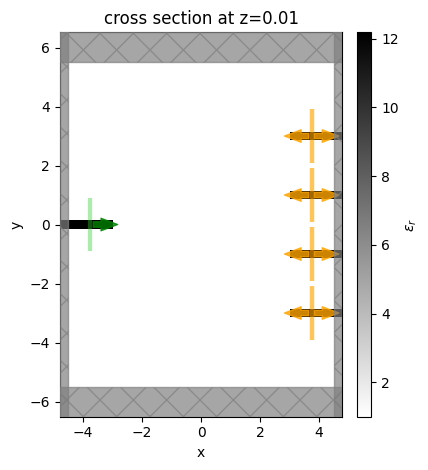

In [4]:
ax = sim_static.plot_eps(z=0.01)
ax.set_aspect("equal")

### Solving modes

Next, we want to ensure that we are injecting and measuring the right waveguide modes at each of the ports.

We'll use `tidy3d`'s `ModeSolver` to analyze the modes of our input waveguide.

In [5]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

# we'll ask for 4 modes just to inspect
num_modes = 4

# let's define how large the mode planes are and how far they are from the PML relative to the design region
mode_size = (0, ly_single, td.inf)

# make a plane corresponding to where we wish to measure the input mode
plane_in = td.Box(
    center=(-Lx / 2 + wg_length / 2.0, 0, 0),
    size=mode_size,
)

mode_solver = ModeSolver(
    simulation=sim_static,
    plane=plane_in,
    freqs=freqs_design,
    mode_spec=td.ModeSpec(num_modes=num_modes),
)

Next we run the mode solver on the servers.

In [6]:
mode_data = run_mode_solver(mode_solver, reduce_simulation=True)

07:08:20 EDT Mode solver created with                                           
             task_id='fdve-243abf0e-12b4-4663-9658-83f6b9839005',               
             solver_id='mo-3c3da415-d6fb-45d4-a3cd-26758e25278c'.

Output()

Output()

07:08:22 EDT Mode solver status: success

Output()

And visualize the results.

Effective index of computed modes:  [[3.1498365 2.8421159 2.0044684 1.0709307]
 [3.1421015 2.820572  1.9686875 1.0634748]
 [3.1343486 2.7986248 1.9328444 1.0572628]
 [3.1265793 2.7762709 1.8969632 1.051999 ]]


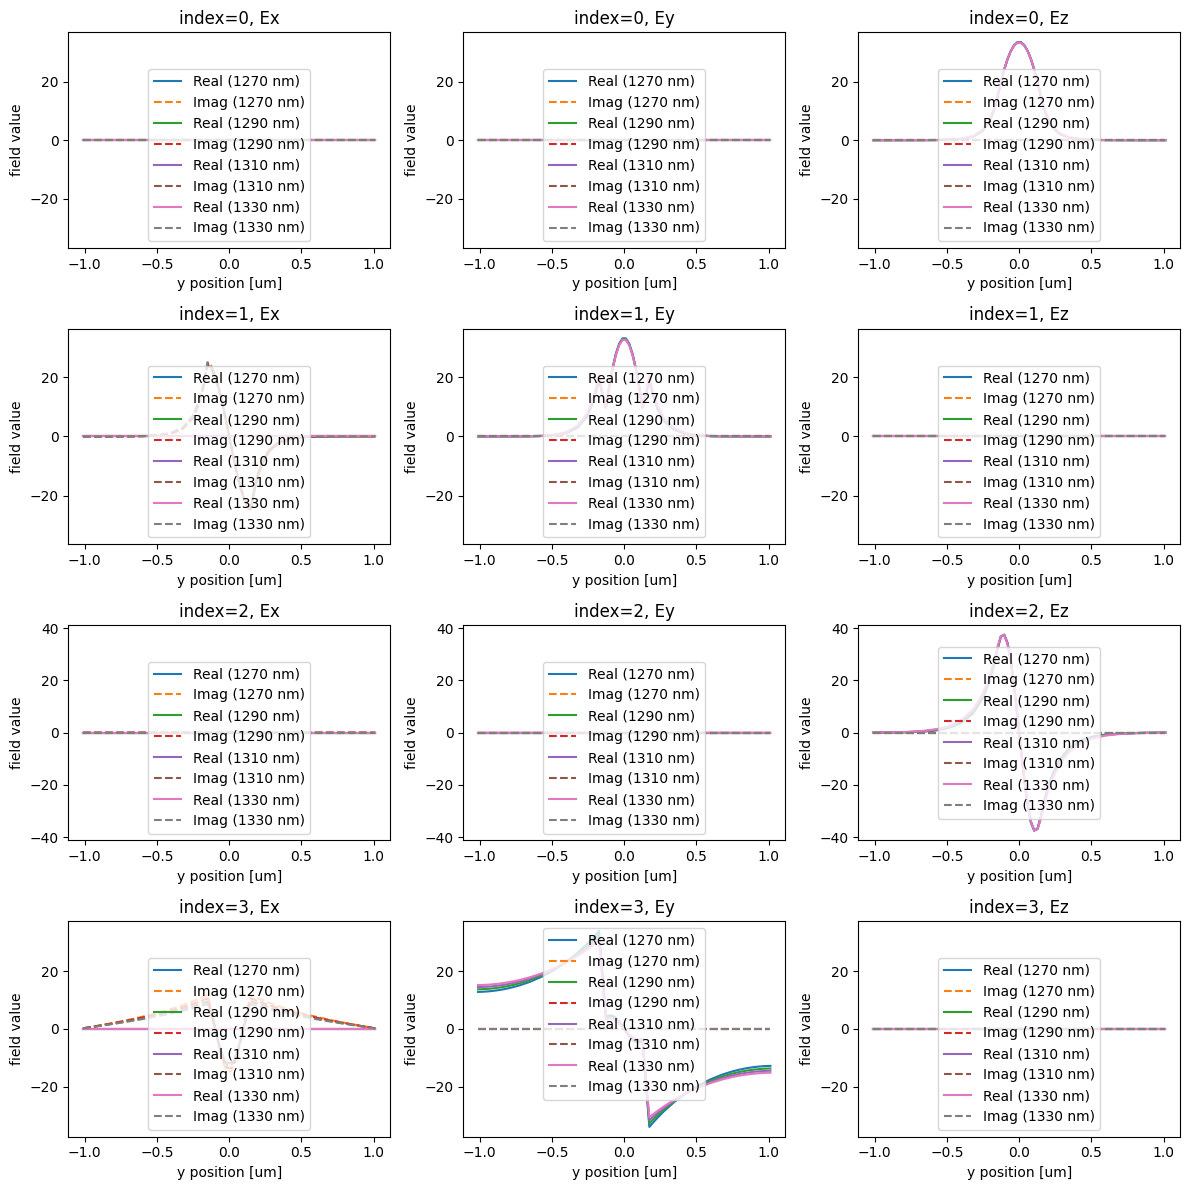

In [7]:
fig, axs = plt.subplots(num_modes, 3, figsize=(12, 12), tight_layout=True)
for mode_index in range(num_modes):
    vmax = 1.1 * max(
        abs(mode_data.field_components[n].sel(mode_index=mode_index)).max()
        for n in ("Ex", "Ey", "Ez")
    )
    for field_name, ax in zip(("Ex", "Ey", "Ez"), axs[mode_index]):
        for freq in freqs_design:
            key = f"{td.C_0 / freq * 1000 :.0f} nm"
            field = mode_data.field_components[field_name].sel(
                mode_index=mode_index, f=freq
            )
            field.real.plot(label=f"Real ({key})", ax=ax)
            field.imag.plot(ls="--", label=f"Imag ({key})", ax=ax)
        ax.set_title(f"index={mode_index}, {field_name}")
        ax.set_ylim(-vmax, vmax)
        ax.legend()

print("Effective index of computed modes: ", np.array(mode_data.n_eff))

We identify `mode_index=0` as the first order mode that is out of plane of the device. Let's choose to optimize our device with respect to this as the mode of interest for both the input and output.

We'll update or static simulation with the new mode index and mode specificiation, in case these are different from the original ones.

In [8]:
mode_index = 0
mode_spec = td.ModeSpec(num_modes=mode_index + 1)

sim_static = sim_static.updated_copy(mode_index=mode_index, path="sources/0")
sim_static = sim_static.updated_copy(mode_spec=mode_spec, path="sources/0")
for i in range(num_freqs_design):
    sim_static = sim_static.updated_copy(mode_spec=mode_spec, path=f"monitors/{i}")

### Define design region

Next, we define the design region as a pixelated grid of permittivity values that get generated from our optimization parameters.

We first define the overall geometry as a `td.Box` and also the number of pixels in x and y staticd on our design region resolution.

In [9]:
nx = int(lx / dl_design_region)
ny = int(ly / dl_design_region)

design_region_geo = td.Box(size=(lx, ly, lz), center=(0, 0, 0))

Next we write a function to give us the pixelated array as a function of our parameters through our filtering and projection methods, which are used to make the resulting structures easier to fabricate. For more details, refer to our 4th lecture in the [inverse design 101 lecture series](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/), which focuses on fabrication constraints.

We also wrap this function in another one that generates the entire `td.Structure` corresponding to the design region, for convenience later.

In [10]:
from tidy3d.plugins.autograd.functions import rescale
from tidy3d.plugins.autograd.invdes import make_filter_and_project, get_kernel_size_px


filter_size = get_kernel_size_px(radius, dl_design_region)
filter_project = make_filter_and_project(filter_size)


def get_density(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the density of material (0, 1) as a function of the parameters (0,1)"""
    return filter_project(params, beta=beta)


def make_eps(params: np.ndarray, beta: float) -> np.ndarray:
    """Construct density values and rescale them to relative permittivity values between air and silicon."""
    density = get_density(params, beta=beta)
    return rescale(density, 1, n_si**2)


def make_custom_medium(params: np.ndarray, beta: float) -> td.Structure:
    """Make td.Structure containing custom medium with the permittivity data as a function of parameters."""
    eps = make_eps(params, beta).reshape((nx, ny, 1))
    xs = anp.linspace(-lx / 2, lx / 2, nx)
    ys = anp.linspace(-ly / 2, ly / 2, ny)
    zs = [0]
    coords = dict(x=xs, y=ys, z=zs)

    eps_arr = td.ScalarFieldDataArray(data=eps, coords=coords)

    medium = td.CustomMedium(permittivity=eps_arr)

    return td.Structure(geometry=design_region_geo, medium=medium)

### Construct Simulation

With all of these functions and variables defined, we can write a single function to return our "static" `td.Simulation` as a function of our design parameters. This function first constructs the design region, a mesh override structure to control the resolution in this region, and then creates a copy of the original `td.Simulation` with all of the basic parameters.

In [11]:
def get_sim(params, beta, include_extra_mnts: bool = True):
    design_region = make_custom_medium(params, beta=beta)

    design_override = td.MeshOverrideStructure(
        geometry=design_region.geometry,
        dl=[dl_design_region, dl_design_region, dl_design_region],
    )
    grid_spec = sim_static.grid_spec.updated_copy(
        override_structures=list(sim_static.grid_spec.override_structures)
        + [design_override]
    )

    update_dict = dict(
        structures=list(sim_static.structures) + [design_region],
        grid_spec=grid_spec,
    )

    # if include_extra_mnts is False, update sim to only include mode monitors, to save data.
    if not include_extra_mnts:
        update_dict["monitors"] = mnts_mode

    return sim_static.updated_copy(**update_dict)

Let's test out our function. We'll make an initially random array of parameters between 0 and 1 and generate the static simulation to plot and inspect.

In [12]:
params0 = np.random.random((nx, ny))
sim0 = get_sim(params0, beta=beta0)

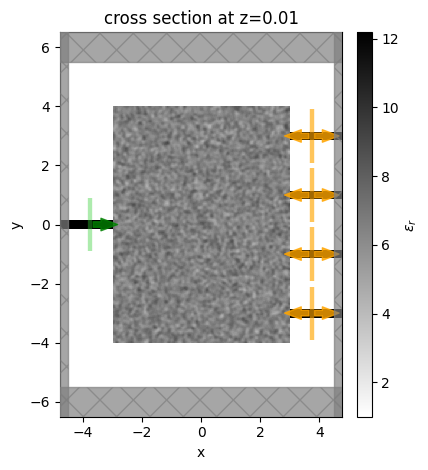

In [13]:
ax = sim0.plot_eps(z=0.01)
ax.set_aspect("equal")

## Defining Objective Function

With our simulation fully defined as a function of our parameters, we are ready to define our objective function.

In this case, it is quite simple, we simply measure the transmitted power in our `n=4` output waveguide modes for each of the `n=4` design frequencies.

Our objective whenn looking at waveguide `i` will be to maximize power transmission at frequency `i`. To reduce cross talk between waveguide `i` and frequency `j != i`, we will subtract the average of the power transmissions for all of the other ports.

Our overall metric will then be the average

In [14]:
import xarray as xr

def average_over_channel(spectrum: xr.DataArray, fmin: float, fmax: float) -> xr.DataArray:
    """Get average of the spectrum within the frequency range between fmin and fmax."""
    freqs = spectrum.f
    freqs_in_channel = np.logical_and(freqs >= fmin, freqs <= fmax).values
    num_freqs = np.sum(freqs_in_channel)
    avg_power = spectrum.values @ freqs_in_channel / num_freqs
    return avg_power

def get_power(sim_data: td.SimulationData, mnt_index: int, freq_index: int) -> float:
    """Get the average power at waveguide `mnt_index` and frequency channel `freq_index`."""
    mnt_name = mnts_mode[mnt_index].name
    mnt_data = sim_data[mnt_name]
    fmin_channel, fmax_channel = channel_bounds[freq_index]
    amp = mnt_data.amps.sel(direction="+", mode_index=0)
    power_spectrum = anp.abs(amp) ** 2
    return average_over_channel(power_spectrum, fmin=fmin_channel, fmax=fmax_channel)

def get_metric(
    sim_data: td.SimulationData, mnt_index: int, leak_weight: float = 1.0
) -> float:
    """measure of how well this channel (`mnt_index`) performs. With an adjustable weight to reduce cross talk influence."""

    power_all = [
        get_power(sim_data=sim_data, mnt_index=mnt_index, freq_index=j)
        for j in range(num_freqs_design)
    ]

    power_transmitted = power_all[mnt_index]

    # remove the extra term of power_self in power_all
    power_leaked = sum(power_all) - power_transmitted
    avg_power_leaked = power_leaked / (num_freqs_design - 1)

    return power_transmitted - leak_weight * avg_power_leaked

Next we add a penalty to produce structures that are invariant under erosion and dilation, which is a useful approach to implementing minimum length scale features.

In [15]:
from tidy3d.plugins.autograd.invdes import make_erosion_dilation_penalty

beta_penalty = 10

penalty = make_erosion_dilation_penalty(filter_size, beta=beta_penalty)

### Total Objective function

Then we write an `objective` function that constructs our simulation, runs it, measures our metric, and subtracts our penalty.

> Note: due to current limitations of the autograd support in tidy3d, when running broadband simulations, one must have only a single output 'port' in the forward simulation. Therefore, we split our problem into one simulation per output waveguide, and then run these in parallel using `web.run_async()`.

In [16]:
# useful for debugging, if you want to turn off the metric or the penalty
use_penalty = True
use_metric = True


def objective(
    params, beta: float, penalty_weight: float = 1.0, leak_weight: float = 0.0
) -> float:
    metric = 0.0
    penalty_value = 0.0

    if use_metric:
        sim = get_sim(params, beta=beta, include_extra_mnts=False)
        simulations = {f"WDM_invdes_{key}": sim for key in keys}
        batch_data = web.run_async(simulations, verbose=False)
        metric = 0.0
        for mnt_index, (_, sim_data) in enumerate(batch_data.items()):
            metric = metric + get_metric(
                sim_data=sim_data, mnt_index=mnt_index, leak_weight=leak_weight
            )
        metric = metric / num_freqs_design

    if use_penalty:
        penalty_value = penalty(params)

    return metric - penalty_weight * penalty_value

### Differentiating the objective

Finally, we can simply use `autograd` (`ag`) to transform this objective function into a function that returns our objective function value and our gradient, which we will feed to the optimizer.th

In [17]:
grad_fn = ag.value_and_grad(objective)

Let's try out our gradient function.

In [18]:
J, grad = grad_fn(params0, beta=1)

In [19]:
print(J)
print(grad.shape)
print(np.linalg.norm(grad))

-0.9538509078814369
(300, 400)
0.043891753310945594


## Run Optimization

Finally, we are ready to optimize our device. We will make use of the `optax` package to define an optimizer using the `adam` method, as we've done in the previous inverse design tutorials.

We record a history of objective function values, and parameters, for visualization later.

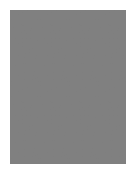

step = 1
	J = -1.0036e+00
	beta = 1.00
	grad_norm = 6.4757e-02


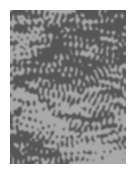

step = 2
	J = -9.9447e-01
	beta = 3.03
	grad_norm = 7.1006e-02


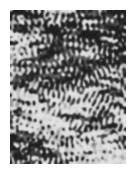

step = 3
	J = -9.8188e-01
	beta = 5.05
	grad_norm = 5.7080e-02


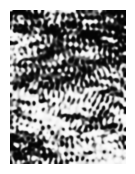

step = 4
	J = -9.5890e-01
	beta = 7.08
	grad_norm = 3.6928e-02


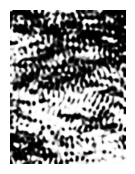

step = 5
	J = -8.9244e-01
	beta = 9.10
	grad_norm = 3.7242e-02


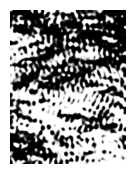

step = 6
	J = -7.8255e-01
	beta = 11.13
	grad_norm = 3.3857e-02


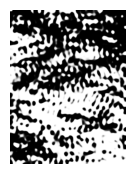

step = 7
	J = -6.7403e-01
	beta = 13.15
	grad_norm = 5.9619e-02


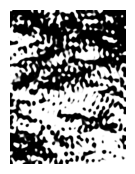

step = 8
	J = -5.9609e-01
	beta = 15.18
	grad_norm = 1.0733e-01


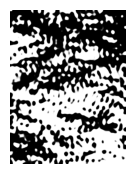

step = 9
	J = -5.5166e-01
	beta = 17.21
	grad_norm = 8.2142e-02


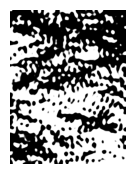

step = 10
	J = -5.1236e-01
	beta = 19.23
	grad_norm = 6.8002e-02


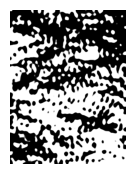

step = 11
	J = -4.8323e-01
	beta = 21.26
	grad_norm = 8.6811e-02


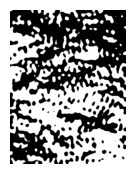

step = 12
	J = -4.1042e-01
	beta = 23.28
	grad_norm = 9.2926e-02


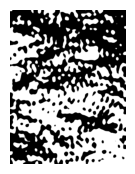

step = 13
	J = -3.4551e-01
	beta = 25.31
	grad_norm = 1.0868e-01


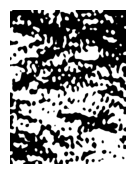

step = 14
	J = -2.7994e-01
	beta = 27.33
	grad_norm = 1.2151e-01


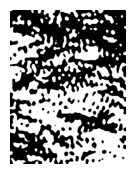

In [ ]:
import optax

# hyperparameters
num_steps = 40
learning_rate = 0.1
beta_min = 1
beta_max = 80

# initialize adam optimizer with starting parameters
params = 0.5 * np.ones_like(params0)

optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [params0]
data_history = []
beta_history = []

for i in range(num_steps):
    perc_done = i / (num_steps - 1)

    # in case we want to change parameters over the optimization procedure
    penalty_weight = 1.0
    leak_weight = 1.0
    beta_i = beta_min * (1 - perc_done) + beta_max * perc_done

    # make a plot of density to check on progress
    density = get_density(params, beta_i)
    plt.subplots(figsize=(2, 2))
    plt.imshow(np.flipud(1 - density.T), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

    # compute gradient and current objective function value
    value, gradient = grad_fn(
        params, beta=beta_i, penalty_weight=penalty_weight, leak_weight=leak_weight
    )

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tbeta = {beta_i:.2f}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)
    params = np.array(params)

    # keep params between 0 and 1
    params = anp.minimum(1.0, params)
    params = anp.maximum(0.0, params)

    # save history
    Js.append(value)
    params_history.append(params)
    beta_history.append(beta_i)

## Visualize Results

Let's visualize the results of our optimization.

### Objective function vs Iteration

First we inspect the objective function value as a function of optimization iteration number. We see that it steadily increases as expected. 

In [1]:
plt.plot(Js)
plt.xlabel("iteration number")
plt.ylabel("objective function")
plt.show()

NameError: name 'plt' is not defined

### Final Simulation

Let's take a look at the final simulation, which we grab from our history.

In [2]:
sim_final = get_sim(params_history[-1], beta=beta_history[-1])

NameError: name 'get_sim' is not defined

In [ ]:
ax = sim_final.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0)

In [ ]:
penalty_value_final = penalty(params_history[-1])
print(penalty_value_final)

In [ ]:
sim_data_final = web.run(sim_final, task_name="wdm_final")

### Flux

Let's inspect the flux over each of the output ports as a function of wavelength.

We notice that the ports have peaks in transmission at their corresponding design wavelengths, and are supressed at the other wavelengths, as expected!

In [ ]:
for i in range(num_freqs_design):
    freq = freqs_design[i]
    flux_data = sim_data_final[mnts_flux[i].name]
    wvl_nm = 1000 * td.C_0 / freq
    wavelengths_nm = 1000 * td.C_0 / np.array(flux_data.flux.f)
    flux = np.array(flux_data.flux.values)
    loss_db = 10 * np.log10(flux)
    label = f"channel @ {int(wvl_nm)} nm"
    plt.plot(wavelengths_nm, loss_db, label=label)
    plt.scatter([wvl_nm], [0], 100, marker="*")
    plt.xlabel("wavelength (nm)")
    plt.ylabel("insertion loss (dB)")
    plt.legend()
    plt.grid("on")

plt.show()

### Fields

Let's also plot the field intensity patterns at each of the design wavelengths. 

We see from this plot the expected result that the power is directed to the design port at each frequency.

In [ ]:
# plot fields at the two design wavelengths

fig, axes = plt.subplots(
    1, num_freqs_design, tight_layout=True, figsize=(15, 1 * num_freqs_design)
)

for freq, ax in zip(freqs_design, axes):
    sim_data_final.plot_field("field", "E", "abs^2", f=freq, ax=ax, vmax=1200)
    wvl = 1000 * td.C_0 / freq
    ax.set_title(f"wavelength = {int(wvl)} nm")

### Animation

Finally, we animate this plot as a function of iteration number. The animation shows the device quickly accomplishing our design objective.

> Note: can take a few minutes to complete

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax1 = fig, axes = plt.subplots(1, 1, tight_layout=False, figsize=(9, 4))


def animate(i):
    sim_i = get_sim(params_history[i], beta_history[i])
    sim_i.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0, ax=ax1)
    ax1.set_aspect("equal")


# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(beta_history))
plt.close()

In [ ]:
# display the animation (press "play" to start)
HTML(ani.to_jshtml())

To save the animation as a file, uncomment the line below

> Note: can take several more minutes to complete

In [ ]:
ani.save("img/animation_wdm_autograd.gif", fps=30)

## Export to GDS
The `Simulation` object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. In addition to a file name, it is necessary to set a cross-sectional plane (`z = 0` in this case) on which to evaluate the geometry, a `frequency` to evaluate the permittivity, and a `permittivity_threshold` to define the shape boundaries in custom mediums. See the [GDS export](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSExport/) notebook for a detailed example on using `.to_gds_file` and other GDS related functions.

In [ ]:
sim_final.to_gds_file(
    fname="./misc/inv_des_wdm_ag.gds",
    z=0,
    permittivity_threshold=(n_si**2 + 1) / 2,
    frequency=freq0,
)